In [100]:
import numpy as np
import xarray as xr
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import f90nml

%matplotlib inline
plt.rcParams['image.cmap'] = 'jet'
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

ImportError: No module named 'pivot_table'

In [2]:
reference_namelist_file = '/data/jpetrie/MEOPAR/SS-run-sets/SS-SMELT/namelists/namelist_pisces_cfg_5x5_NewIC'
reference_bio_params = f90nml.read(reference_namelist_file)

In [4]:


grid_heights = np.array(mesh_mask['e3t_1d'][0])

depths = mesh_mask.gdept_1d.values[0]



In [32]:
def mean_tracer_at_depth(grid_t, tracer_name):
    t = np.array([float(x) for x in grid_t.time_centered.values])   
    days = (t[:] - t[0])/10**9/3600/24
    min_day_index = np.argmax(days > 30)
    max_day_index = len(days)

    grid_heights = grid_t.deptht_bounds.values[:,1] - grid_t.deptht_bounds.values[:,0]
    depths = grid_t.deptht.values
    min_depth_index = np.argmax(depths > 150)
    max_depth_index = len(depths)
    
    tracer_quantity_array = ((grid_t[tracer_name].values)*(grid_heights.reshape((1,40,1,1))))
    total_tracer_at_depth = tracer_quantity_array[min_day_index:max_day_index, min_depth_index:max_depth_index,:,:].sum()
    mean_tracer = total_tracer_at_depth/sum(grid_heights[min_depth_index:max_depth_index])/(max_day_index - min_day_index)
    mean_tracer = mean_tracer/15 #  number of non-zero grid elements in 5x5 model
    return(mean_tracer) 

In [38]:
def mean_NH4_at_depth(grid_t):
    return(mean_tracer_at_depth(grid_t, "NH4"))
def mean_NO3_at_depth(grid_t):
    return(mean_tracer_at_depth(grid_t, "NO3"))
def mean_DON_at_depth(grid_t):
    return(mean_tracer_at_depth(grid_t, "DOC"))
def mean_PON_at_depth(grid_t):
    return(mean_tracer_at_depth(grid_t, "POC"))

In [87]:
def time_of_peak_PHY2(grid_t):
    t = np.array([float(x) for x in grid_t.time_centered.values])   
    days = (t[:] - t[0])/10**9/3600/24
    
    phy2_qunatity_array = ((grid_t["PHY2"].values)*(grid_heights.reshape((1,40,1,1))))
    total_phy2 = phy2_qunatity_array.sum((1,2,3))
    bloom_time = days[np.argmax(total_phy2)]
    return(bloom_time)

In [93]:
def time_surface_NO3_drops_below_4(grid_t):
    t = np.array([float(x) for x in grid_t.time_centered.values])   
    days = (t[:] - t[0])/10**9/3600/24
    mean_surface_NO3 = np.sum(((grid_t.variables["NO3"][:,:,1,1]*grid_heights.reshape((1,40)))[:,:10]/sum(grid_heights[:10])), axis = 1)
    bloom_time = days[np.argmax(mean_surface_NO3 < 4)]
    return(bloom_time)

In [81]:
t = np.array([float(x) for x in grid_t.time_centered.values])   
days = (t[:] - t[0])/10**9/3600/24

phy2_qunatity_array = ((grid_t["PHY2"].values)*(grid_heights.reshape((1,40,1,1))))
total_phy2 = phy2_qunatity_array.sum((1,2,3))
days[np.argmax(total_phy2)]

21.041666666666668

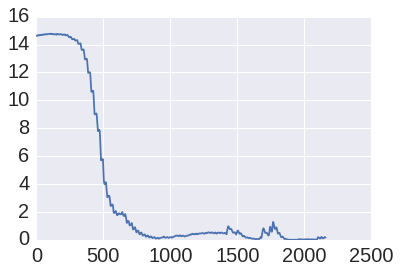

In [91]:
mean_surface_NO3 = np.sum(((grid_t.variables["NO3"][:,:,1,1]*grid_heights.reshape((1,40)))[:,:10]/sum(grid_heights[:10])), axis = 1)
plt.plot(range(2160), mean_surface_NO3)

In [84]:
grid_heights[:10]

array([ 1.00000115,  1.00000501,  1.00001253,  1.00002718,  1.0000557 ,
        1.00011125,  1.00021946,  1.0004302 ,  1.00084067,  1.00164012])

In [106]:
tracer_file = 'SS5x5_1h_20150201_20150501_ptrc_T.nc'

param_metrics = pd.DataFrame()

batch_directories = [
                     #'/data/jpetrie/MEOPAR/SalishSea/results/nampiszoo_june_14/',
                     '/data/jpetrie/MEOPAR/SalishSea/results/nampissink_june_8/',
]

metric_func_list = [
                    mean_NH4_at_depth,
                    mean_NO3_at_depth,
                    mean_DON_at_depth,
                    mean_PON_at_depth,
                    time_of_peak_PHY2,
                    time_surface_NO3_drops_below_4,
]

for batch_dir in batch_directories:
    for file in os.listdir(batch_dir):
        if os.path.isfile(batch_dir + '/' + file + '/' + tracer_file):
            last_underscore = file.rfind('_')
            first_underscore = file.find('_')
            param_name = file[:last_underscore]
            param_val = float(file[(last_underscore+1):])
            param_scale = round(param_val/reference_bio_params[file[:first_underscore]][file[(first_underscore+1):last_underscore]], 3)
            grid_t = xr.open_dataset(batch_dir + '/' + file +'/' + tracer_file)
            
            for metric_func in metric_func_list:
                metric_val = metric_func(grid_t)
                metric_name = metric_func.__name__
                # inefficient to keep appending, but much less expensive than other parts of the loop so it doesn't matter
                param_metrics = param_metrics.append(pd.DataFrame({"PARAM_NAME":[param_name], "PARAM_VAL":[param_val],"PARAM_SCALE":[param_scale], "METRIC_NAME":[metric_name], "METRIC_VAL": [metric_val]}))




/home/jpetrie/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


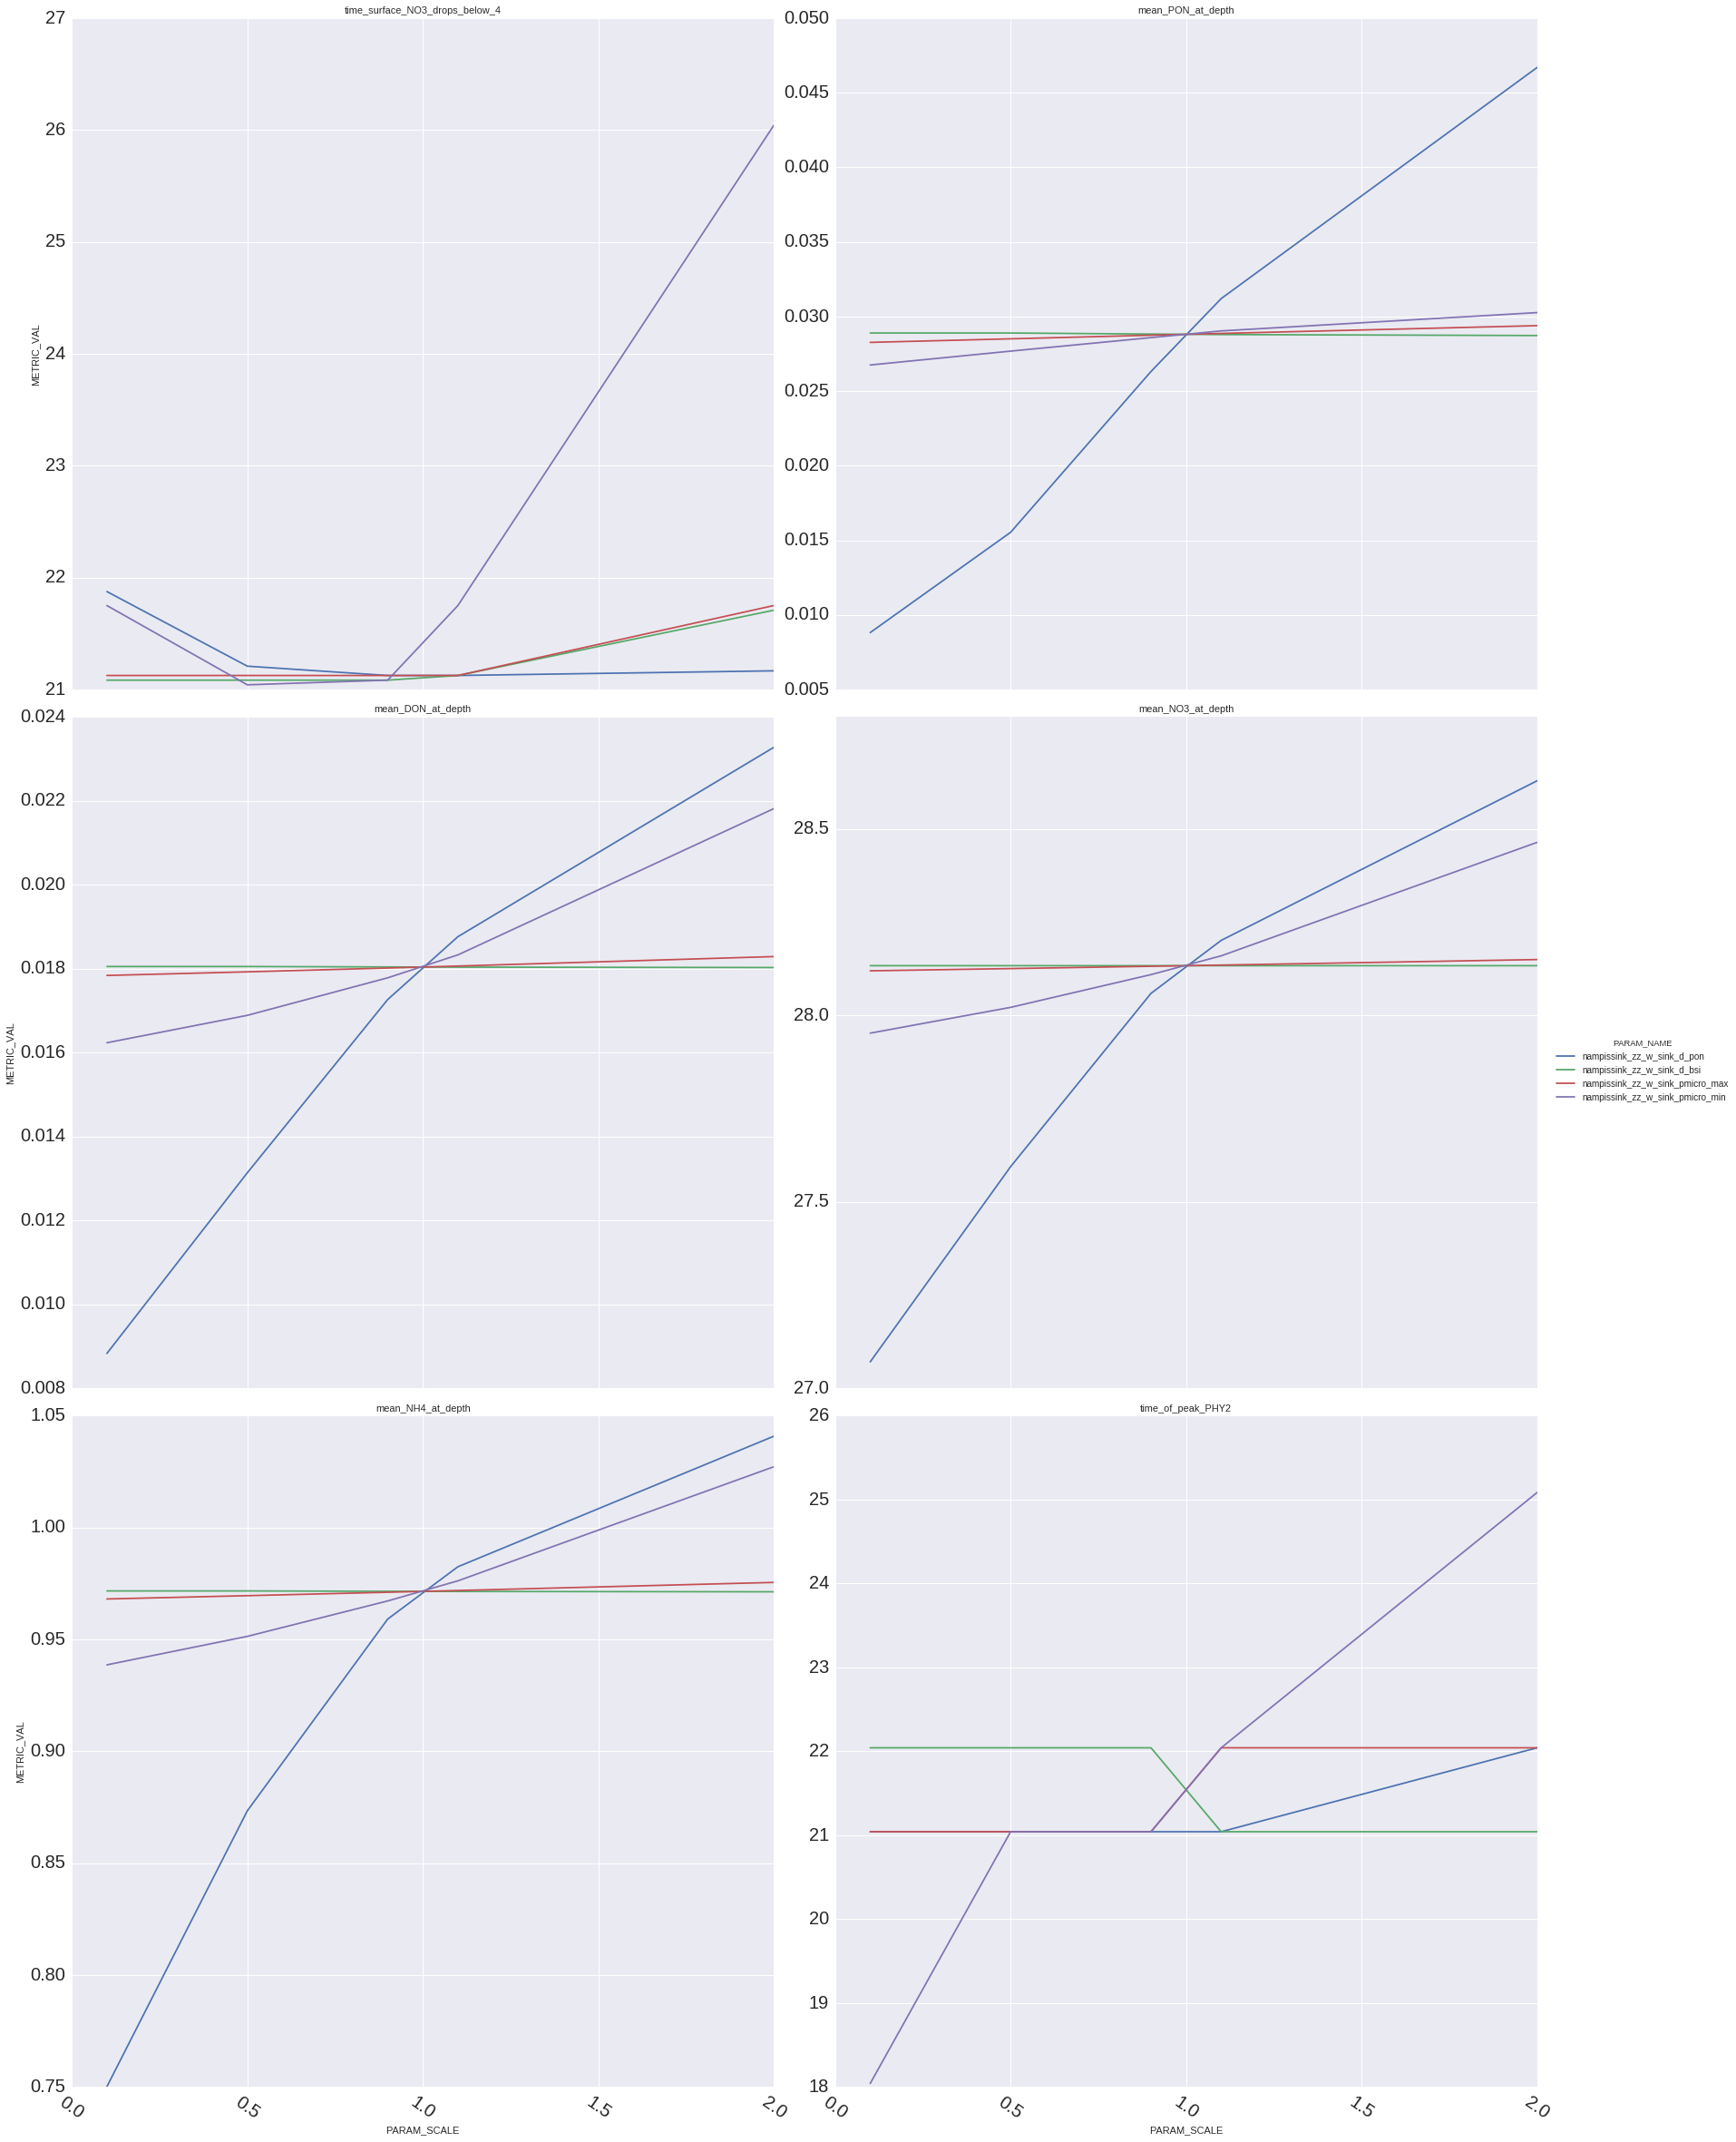

In [96]:
param_metrics = param_metrics.sort_values("PARAM_SCALE")

fg = sns.FacetGrid(data=param_metrics.query("PARAM_SCALE < 10"), col = "METRIC_NAME", hue = "PARAM_NAME",  sharey=False, col_wrap = 2, size = 12)
fg.map(plt.plot, "PARAM_SCALE", "METRIC_VAL").add_legend()
fg.set_xticklabels(rotation=-35)
plt.subplots_adjust(top=0.9)
#fg.set(xlim=(0, max(param_vals)))
fg.set_titles("{col_name}")

In [110]:
wide_format_metrics = pd.pivot_table(param_metrics, values='METRIC_VAL', index=['PARAM_NAME', 'METRIC_NAME'], columns=['PARAM_SCALE'])
wide_format_metrics.reset_index(inplace=True)
wide_format_metrics["SLOPE"] = (wide_format_metrics[1.1] - wide_format_metrics[0.9])/0.2
fg = sns.FacetGrid(data=param_metrics.query("PARAM_SCALE < 10"), col = "METRIC_NAME", hue = "PARAM_NAME",  sharey=False, col_wrap = 2, size = 12)
fg.map(plt.plot, "PARAM_SCALE", "METRIC_VAL").add_legend()wide_format_metrics

PARAM_SCALE,PARAM_NAME,METRIC_NAME,0.1,0.5,0.9,1.1,2.0,10.0,SLOPE
0,nampissink_zz_w_sink_d_bsi,mean_DON_at_depth,0.018051,0.018051,0.018041,0.018036,0.018027,0.018019,-0.000024
1,nampissink_zz_w_sink_d_bsi,mean_NH4_at_depth,0.971662,0.971662,0.971501,0.971426,0.971280,0.971138,-0.000379
2,nampissink_zz_w_sink_d_bsi,mean_NO3_at_depth,28.132950,28.132950,28.132932,28.132924,28.132921,28.132947,-0.000040
3,nampissink_zz_w_sink_d_bsi,mean_PON_at_depth,0.028894,0.028894,0.028825,0.028791,0.028725,0.028656,-0.000167
4,nampissink_zz_w_sink_d_bsi,time_of_peak_PHY2,22.041667,22.041667,22.041667,21.041667,21.041667,21.041667,-5.000000
5,nampissink_zz_w_sink_d_bsi,time_surface_NO3_drops_below_4,21.083333,21.083333,21.083333,21.125000,21.708333,21.750000,0.208333
6,nampissink_zz_w_sink_d_pon,mean_DON_at_depth,0.008829,0.013135,0.017264,0.018761,0.023274,0.018340,0.007488
7,nampissink_zz_w_sink_d_pon,mean_NH4_at_depth,0.750153,0.873387,0.959082,0.982465,1.040791,0.929375,0.116917
8,nampissink_zz_w_sink_d_pon,mean_NO3_at_depth,27.070724,27.594037,28.058710,28.200763,28.628638,28.288216,0.710268
9,nampissink_zz_w_sink_d_pon,mean_PON_at_depth,0.008814,0.015536,0.026316,0.031202,0.046691,0.033996,0.024428


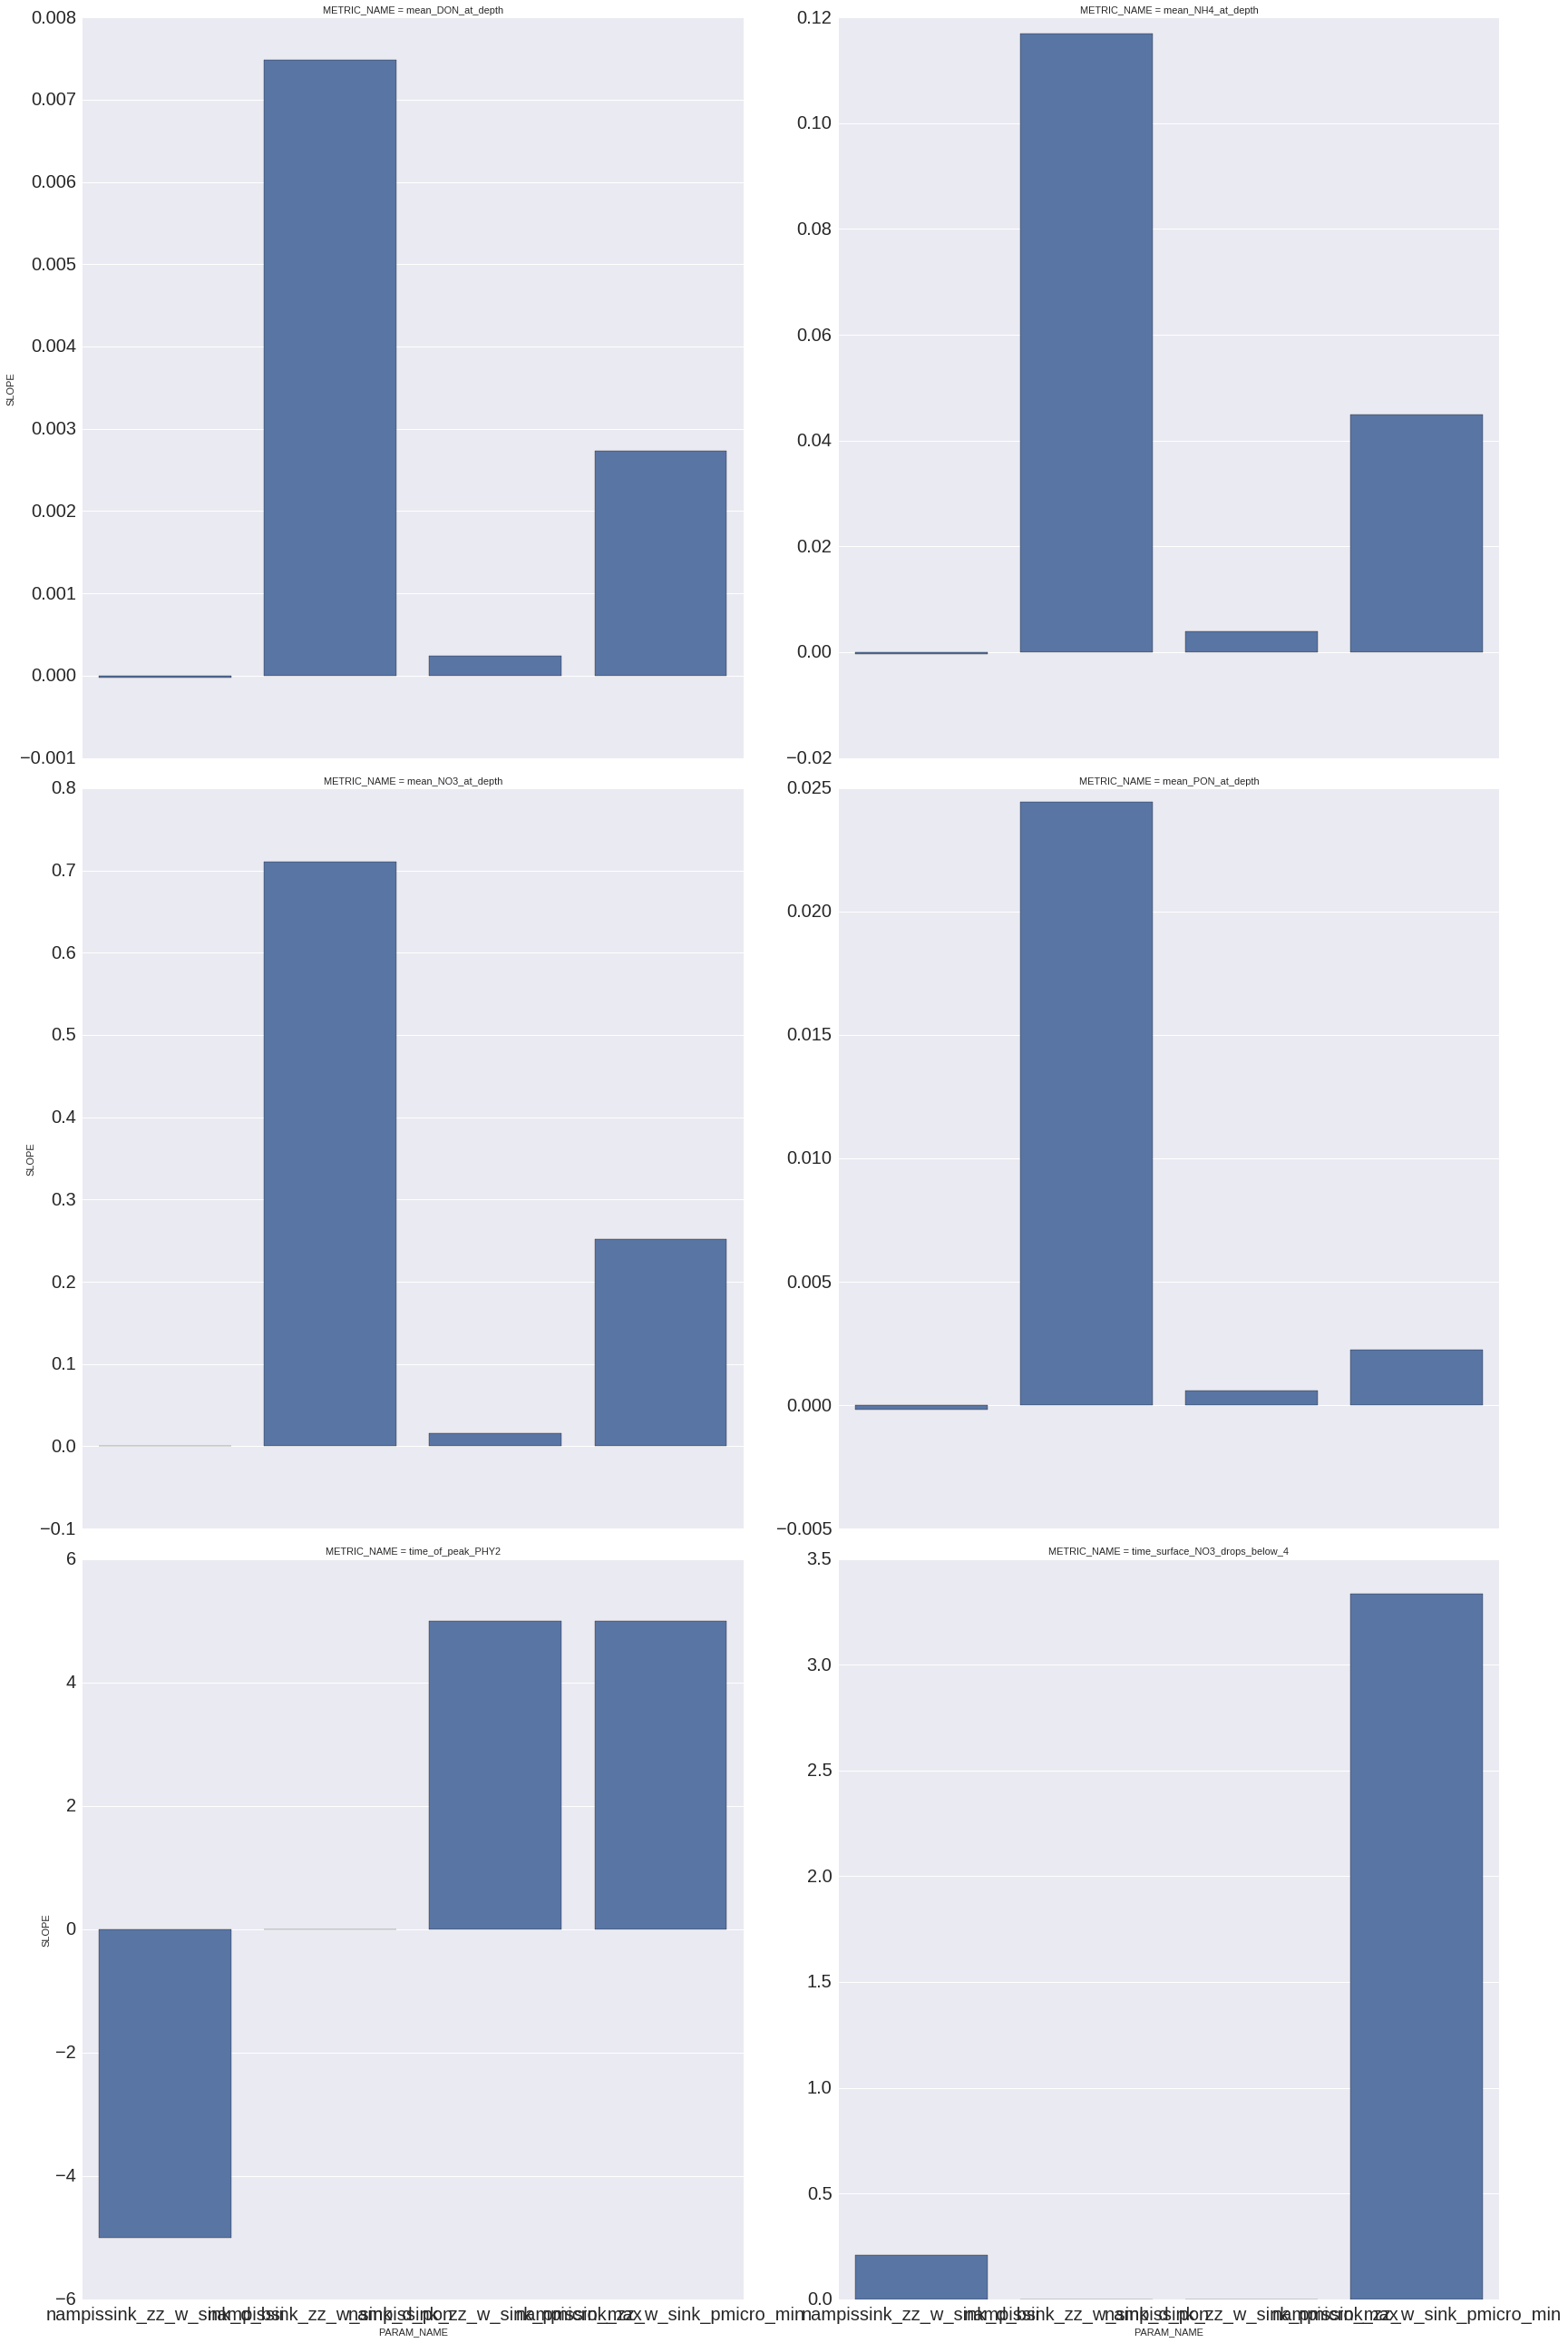

In [115]:
fg = sns.FacetGrid(data=wide_format_metrics, col = "METRIC_NAME", col_wrap = 2, size = 12, sharey = False)
fg.map(sns.barplot, "PARAM_NAME", "SLOPE")

#sns.barplot(data = wide_format_metrics.query("METRIC_NAME == 'mean_DON_at_depth'"), x = "PARAM_NAME", y = "SLOPE" )